In [169]:
import pandas as pd
import sys
import blosum as bl
from Bio import SeqIO
import glob
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [222]:
library = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/libraries/sequence/AF2_PRED/DEATH-ref/DEATH-ref_sequence.library"
newval = 100
outname = "test.lib"
mat3di = "/home/luisasantus/Desktop/crg_cluster/data/structural_regression/sub_matrices/3di.mat"
matrix = bl.BLOSUM(mat3di)
alphabet = "ACDEFGHIKLMNPQRSTVWYX"
windowsize = 20
library = "/home/luisasantus/Desktop/TEST/TEST_3di.library"

/home/luisasantus/anaconda3/lib/python3.9/site-packages/blosum/_blosum.py:125: UserWarning: Blosum matrix may not cover all amino-acids
  warn(UserWarning("Blosum matrix may not cover all amino-acids"))


In [ ]:
# Quick ad dirty - estimate frequencies 

In [89]:
fastas_3di = glob.glob("/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/alphabet/3di_fasta/AF2_PRED/*/*.3di.fa")

# Get counts and frequencies
count_aa = dict([(i,0) for i in alphabet])
for fasta_3di in fastas_3di: 
    for record in SeqIO.parse(fasta_3di, "fasta"): 
        for aa in count_aa:
            count_aa[aa] += record.seq.count(aa)

tot = sum(count_aa.values())

freq_aa = dict([(i,0) for i in alphabet])
for aa in count_aa: 
    freq_aa[aa] = count_aa[aa]/tot

In [249]:
freq_aa

{'A': 0.048503611971104234,
 'C': 0.03762704443818995,
 'D': 0.12771054195202802,
 'E': 0.02126528442317916,
 'F': 0.03314882571848516,
 'G': 0.03684523251086719,
 'H': 0.03867154517309316,
 'I': 0.020277074147043186,
 'K': 0.02105888607436595,
 'L': 0.08265315695656253,
 'M': 0.010445007349032117,
 'N': 0.03206054351565187,
 'P': 0.08381023860900022,
 'Q': 0.06208837602026457,
 'R': 0.04089814554210839,
 'S': 0.07782468649341714,
 'T': 0.01983925946774244,
 'V': 0.16124714638646528,
 'W': 0.02242236607561685,
 'Y': 0.021603027175782594,
 'X': 0.0}

In [12]:
def print_lib(library):
    with open(library, 'r') as file:
        lines = file.readlines()
        for line in lines: 
            print(line)
def get_exp_score(aa_i):
    expected_score = 0
    for aa in alphabet: 
        expected_score += freq_aa[aa] * matrix[aa_i][aa]
    return expected_score

def get_delta(seq, i):
    # i starts from 1
    i = i - 1 
    left_i = max(0,i-windowsize)
    right_i = min(len(seq), i+windowsize)
    local_avg = 0 
    range_j = range(left_i, right_i)
    for j in range_j: 
        if i !=j: 
            local_avg += matrix[seq[i]][seq[j]]
    local_avg = local_avg/len(range_j)
    exp_score = get_exp_score(seq[i])
    delta =  - local_avg * (1/2*windowsize) + exp_score
    return(delta)

In [162]:
# Read in the fasta with 3di information 
fasta_3di = "/home/luisasantus/Desktop/crg_cluster/projects/structural_regression/results/homfam/alphabet/3di_fasta/AF2_PRED/DEATH-ref/DEATH-ref.3di.fa"
seq_3di = {}
for record in SeqIO.parse(fasta_3di, "fasta"):
    seq_3di[record.id] = str(record.seq)
    #print(str(record.seq))

#  HOMOPOLYMERS BEHAVIOUR EXTREME EXAMPLE

In [215]:

def get_summary_lib(library):
    file1 = open(library, 'r')
    Lines = file1.readlines()


    count = 0
    header_finished = False

    seq_indexes = pd.DataFrame()
    residues = pd.DataFrame()

    # Strips the newline character
    for line in Lines:
        if line.startswith("!"):
            count += 1
            continue
        if count == 0:
            count += 1
            continue
        elif count == 1: 
            nseq = int(line)
            count += 1
            continue
        elif count == nseq+2: 
            header_finished = True

        if not header_finished: 
            count += 1
            # ----- PARSE INDEXES SEQUENCES 
            seq_id = line.split()[0]
            seq = line.split()[2]
            idx_seq = count-2
            entry = pd.DataFrame({"index":[idx_seq], "seq_name":[seq_id]})
            seq_indexes = pd.concat([seq_indexes, entry])
        else:
            # ------- PARSE RESIDUES 
            if line.startswith("#"): 
                seq1 = line.replace("#","").split(" ")[0]
                seq2 = line.replace("#","").split(" ")[1]
            else:
                res1 = line.split()[0]
                res2 = line.split()[1]
                value = line.split()[2]
                res_entry = pd.DataFrame({"seq1":[seq1], "seq2":[seq2], "res1":[res1], "res2":[res2], "value":[value]})
                residues = pd.concat([residues,res_entry])
    residues["id"] = residues.seq1+"-"+residues.seq2+"-"+residues.res1+"-"+residues.res2
    return(residues)

def get_max_residues(res):
    res['seq1'] = pd.to_numeric(res['seq1'])
    res['seq2'] = pd.to_numeric(res['seq2'])
    res['res1'] = pd.to_numeric(res['res1'])
    res['value'] = pd.to_numeric(res['value'])
    res = res.reset_index().drop("index", axis = 1)
    max_rows = res.groupby(['seq1', 'seq2', 'res1'])['value'].idxmax()
    # Keep only the selected rows
    res = res.loc[max_rows]
    return(res)


def plot_library(df, n = 1 ):
    cmap = "flare"
    size_fig = 0.7
    df = df[df.seq1 == (n)]
    f, ax = plt.subplots(figsize=(17*size_fig,5*size_fig ))
    df.value = df.value.astype(float)
    df.res1 = df.res1.astype(float)
    df.seq2 = df.seq2.astype(str)
    ax = sns.scatterplot(data = df, x = "res1", y = "seq2", s = 20, hue = "value", palette = cmap) 
    ax.legend(bbox_to_anchor=(1.02, 1.05))
    ax.set(xlabel = "residue of seq1")
    return(ax)


In [206]:
res = get_max_residues(get_summary_lib(library))
res["library"] = "TEST"
n = 1
plot_library(res, n)

/tmp/ipykernel_12148/811812783.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.value = df.value.astype(float)
/tmp/ipykernel_12148/811812783.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.res1 = df.res1.astype(float)
/tmp/ipykernel_12148/811812783.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

<AxesSubplot:xlabel='residue of seq1', ylabel='seq2'>

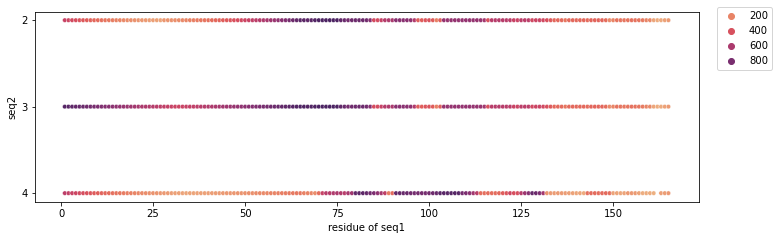

In [286]:
windowsize = 60

# Correct the library and visualize 

In [287]:
def modify_value(line, newval):
    # Split the line into a list of values using tabs as the separator    
    values = line.split()
    if len(values) >= 3:
        values[2] = str(newval)
    # Join the modified values back into a single line using tabs
    modified_line = "\t".join(values)
    return modified_line+"\n"



filename = "/home/luisasantus/Desktop/TEST/TEST_3di_MOD.library"
with open(filename, 'w') as file:
    file1 = open(library, 'r')
    Lines = file1.readlines()
    count = 0
    header_finished = False

    seq_indexes = pd.DataFrame()
    residues = pd.DataFrame()

    # Strips the newline character
    for line in Lines:
        line_print = line
        if line.startswith("!"):
            count += 1
            file.write(line_print)
            continue
        if count == 0:
            count += 1
            file.write(line_print)
            continue
        elif count == 1: 
            nseq = int(line)
            count += 1
            file.write(line_print)
            continue
        elif count == nseq+2: 
            header_finished = True

        if not header_finished: 
            count += 1
            # ----- PARSE INDEXES SEQUENCES 
            seq_id = line.split()[0]
            seq = line.split()[2]
            idx_seq = count-2
            entry = pd.DataFrame({"index":[idx_seq], "seq_name":[seq_id], "seq":[seq], "seq_3di": [seq]})
            seq_indexes = pd.concat([seq_indexes, entry])
        else:
            # ------- PARSE RESIDUES 
            if line.startswith("#"): 
                seq1 = line.replace("#","").split(" ")[0]
                seq2 = line.replace("#","").split(" ")[1]
            else:
                res1 = line.split()[0]
                res2 = line.split()[1]
                value = line.split()[2]
                #print("res1 = " + str(res1))
                #print("res2 = " + str(res2))
                seq_3di_1 = seq_indexes[seq_indexes["index"] == int(seq1)].seq_3di[0]
                seq_3di_2 = seq_indexes[seq_indexes["index"] == int(seq2)].seq_3di[0]
                res1_CHR = seq_3di_1[int(res1)-1]
                res2_CHR = seq_3di_2[int(res2)-1]
                #print(res1_CHR)
                #print(res2_CHR)
                print("delta 1: " + str(get_delta(seq_3di_1, int(res1))))
                print("delta 2: " + str(get_delta(seq_3di_2, int(res2))))
                s1 = max(0, int(res1)-windowsize)
                s2 = max(0, int(res2)-windowsize)
                e1 = min(len(seq_3di_1)-1, int(res1)+windowsize)
                e2 = min(len(seq_3di_2)-1, int(res2)+windowsize)
                print(seq_3di_1[s1:e1])
                print(seq_3di_2[s2:e2])
                delta = sum([get_delta(seq_3di_1, int(res1)), get_delta(seq_3di_2, int(res2))])/2
                print("delta: " + str(delta))
                #print("substitution score "+ str(matrix[res1_CHR][res2_CHR]))
                perc_change = delta*100/(matrix[res1_CHR][res2_CHR]+0.1)* np.sign(matrix[res1_CHR][res2_CHR])
                print(delta)
                if perc_change < 0: 
                    newval = max(0,int(value)*(1+perc_change/100))
                    newval = min(newval, 1000)
                else: 
                    newval = value 
                
                #print("current value: "+ str(value))
                #print("new val : "+ str(newval))
                #print("----")
                res_entry = pd.DataFrame({"seq1":[seq1], "seq2":[seq2], "res1":[res1], "res2":[res2], "value":[value]})
                residues = pd.concat([residues,res_entry])
                line_print = modify_value(line, newval)
        file.write(line_print)
    residues["id"] = residues.seq1+"-"+residues.seq2+"-"+residues.res1+"-"+residues.res2


delta 1: -119.05921756262313
delta 2: -56.55921756262313
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDF
delta: -87.80921756262313
-87.80921756262313
delta 1: -119.09200444786903
delta 2: -55.64938149704936
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFL
delta: -87.3706929724592
-87.3706929724592
delta 1: -119.12373369165539
delta 2: -52.83341111101023
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLV
delta: -85.97857240133281
-85.97857240133281
delta 1: -119.15445565786122
delta 2: -50.58302708643265
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVV
delta: -84.86874137214693
-84.86874137214693
delta 1: -119.18421756262313
delta 2: -50.58302708643265
DDDDDDDDDDDDDDDDDDDDDDDDDDDDD

delta 2: -23.107410333707474
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCV
delta: -35.63471581732418
-35.63471581732418
delta 1: -46.61477311817869
delta 2: -25.874032377437953
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVL
delta: -36.24440274780832
-36.24440274780832
delta 1: -46.61477311817869
delta 2: -24.107998050428016
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLC
delta: -35.36138558430335
-35.36138558430335
delta 1: -46.61477311817869
delta 2: -23.107410333707474
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVV

delta 1: -4.8318416361760015
delta 2: -30.54542952747287
DDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPV
VPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDD
delta: -17.688635581824435
-17.688635581824435
delta 1: -4.8318416361760015
delta 2: -26.495009359405643
DDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPV
PDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: -15.663425497790822
-15.663425497790822
delta 1: -4.8318416361760015
delta 2: 23.416566715018725
DDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPV
PCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: 9.2923625

delta 1: 127.94323298903343
delta 2: 23.416566715018725
DPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
PCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: 75.67989985202608
75.67989985202608
delta 1: 127.94323298903343
delta 2: 52.19078243737687
DPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
VQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: 90.06700771320516
90.06700771320516
delta 1: 127.94323298903343
delta 2: 51.72559256395915
DPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
QVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: 89.8344127764963
89.8344127764963
delta 1: 127.94323298903343
delta 2: 51.248474745069174
DPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
VPDRSSSSSV

delta 1: -119.09200444786903
delta 2: -119.09200444786903
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
delta: -119.09200444786903
-119.09200444786903
delta 1: -119.09200444786903
delta 2: -119.12373369165539
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
delta: -119.10786906976222
-119.10786906976222
delta 1: -119.12373369165539
delta 2: -119.12373369165539
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
delta: -119.12373369165539
-119.12373369165539
delta 1: -119.12373369165539
delta 2: -119.15445565786122
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD
delta: -119.1390946747583
-119.1390946747583
delta 1: -119.15445565786122
delta 2: -119.15445565786122
DDDDDDDDDDDDDD

delta 1: -53.77766416456488
delta 2: -57.564071931555176
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDP
delta: -55.67086804806003
-55.67086804806003
delta 1: -53.77766416456488
delta 2: -57.30921756262313
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPV
delta: -55.54344086359401
-55.54344086359401
delta 1: -53.77766416456488
delta 2: -55.91636041976599
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVV
delta: -54.84701229216543
-54.84701229216543
delta 1: -52.11690987031544
delta 2: -57.564071931555176
DDDDDD

delta 1: 33.350251743440595
delta 2: 26.100251743440598
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNV
DDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVC
delta: 29.725251743440595
29.725251743440595
delta 1: 33.350251743440595
delta 2: 19.600251743440598
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNV
DDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVC
delta: 26.475251743440595
26.475251743440595
delta 1: -1.795429527472871
delta 2: 3.204570472527129
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVS
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVS
delta: 0.70457047

DDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
DPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: 8.006732669294735
8.006732669294735
delta 1: 18.145097449168947
delta 2: -20.812340119460863
DDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
VVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: -1.333621335145958
-1.333621335145958
delta 1: 17.201701222753854
delta 2: 16.201701222753854
DDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
DDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVV
delta: 16.701701222753854
16.701701222753854
delta 1: 17.201701222753854
delta 2: 15.201701222753854
DDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVV

delta 1: -36.14542952747287
delta 2: -3.4789004597054136
VVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
SVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: -19.812164993589143
-19.812164993589143
delta 1: -36.14542952747287
delta 2: -4.468205272539638
VVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
VVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: -20.306817400006253
-20.306817400006253
delta 1: -4.014514993462362
delta 2: 2.0996604064273225
VLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
VLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: -0.9574272935175199
-0.9574272935175199
delta 1: -4.014514993462362
delta 2: -32.980212136168525
VLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
VSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
delta: -18.497363564815444
-18.49736356481

delta 1: -67.98229448570005
delta 2: -13.392550895956468
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPD
delta: -40.68742269082826
-40.68742269082826
delta 1: -67.98229448570005
delta 2: -14.575701079106652
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDP
delta: -41.27899778240335
-41.27899778240335
delta 1: -66.27660886697096
delta 2: -42.01159851500409
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLL
delta: -54.14410369098752
-54.14410369098752
delta 1: -66.27660886697096
delta 2: -39.49671756262313
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVV
DDDDDDDDDDDDDDD

delta 2: 20.028827898269704
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVS
delta: 19.375088027378588
19.375088027378588
delta 1: 18.721348156487476
delta 2: 19.807511648997718
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSC
delta: 19.2644299027426
19.2644299027426
delta 1: 51.100251743440595
delta 2: 16.023979735434846
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHP
delta: 33.56211573943772
33.56211573943772
delta 1: 51.100251743440595
delta 2: -13.956841636176001
DDDDDDD

delta 1: -31.95137012153228
delta 2: -26.058943040986385
PFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
VVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -29.00515658125933
-29.00515658125933
delta 1: -31.95137012153228
delta 2: -24.21209619413954
PFAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
LLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -28.08173315783591
-28.08173315783591
delta 1: -32.24542952747287
delta 2: -26.058943040986385
FAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
VVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -29.15218628422963
-29.15218628422963
delta 1: -32.24542952747287
delta 2: -25.14816925350027
FAQLVPPDPVLLVVLLVVCVVVVCLVVLCVLVVPDPVLVVVLVVCVVVVHRSVSSVCCVVRNVVRDGVVVVLVSCLVVVVVVSNVSCVVRDDPVSNVS
VLLVLCDDCNLVQLCVLLVDDPVV

delta 2: -116.58160562232463
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPV
delta: -82.49228659247387
-82.49228659247387
delta 1: -48.40296756262313
delta 2: -113.55921756262313
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVV
delta: -80.98109256262313
-80.98109256262313
delta 1: -48.40296756262313
delta 2: -110.62443495392748
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVP
delta: -79.5137012582753
-79.5137012582753
delta 1: -48.40296756262313
delta 2: -109.48778899119456
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPL
delta: -78.94537827690885
-78.94537827690885
delta 1: -48.40296756262313
delta 2: -106.27048516825694
DDDDDDDDDDDDDDDDDDD

delta 1: -31.4758842292898
delta 2: -102.56606687769163
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLP
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQP
delta: -67.02097555349071
-67.02097555349071
delta 1: -31.4758842292898
delta 2: -101.59975810316367
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLP
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPD
delta: -66.53782116622673
-66.53782116622673
delta 1: -31.4758842292898
delta 2: -101.85921756262313
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLP
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDP
delta: -66.66755089595647
-66.66755089595647
delta 1: -31.4758842292898
delta 2: -100.92763861525471
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLP
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPC
delta: -66.20176142227226
-66.201761422

delta 1: -27.309217562623136
delta 2: -85.63753081563517
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVL
delta: -56.47337418912915
-56.47337418912915
delta 1: -27.309217562623136
delta 2: -83.20207470548027
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLL
delta: -55.2556461340517
-55.2556461340517
delta 1: -27.309217562623136
delta 2: -56.9415705037996
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDD
delta: -42.12539403321137
-42.12539403321137
delta 1: -27.309217562623136
delta 2: -57.564071931555176
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD

delta 1: 31.600251743440598
delta 2: 31.600251743440598
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVV
delta: 31.600251743440598
31.600251743440598
delta 1: 6.204570472527129
delta 2: 6.204570472527129
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVN
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVN
delta: 6.204570472527129
6.204570472527129
delta 1: 5.454570472527129
delta 2: 5.454570472527129
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNN
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNN
delta: 5.4545704725271

delta 1: -33.59442883022877
delta 2: -39.88274697438784
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPV
delta: -36.73858790230831
-36.73858790230831
delta 1: -33.59442883022877
delta 2: -38.01573930175356
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVV
delta: -35.80508406599117
-35.80508406599117
delta 1: -33.59442883022877
delta 2: -36.20207470548028
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVL
delta: -34.898251767854525
-34.898251767854525
delta 1: -33.59442883022877
delta 2: -34.01696404149637
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVL
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLV
delta: -33.80569643586257
-33.80569643586257
delta 1: -31.475

delta 1: -10.015515105563757
delta 2: -13.076739595359676
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSS
delta: -11.546127350461717
-11.546127350461717
delta 1: 20.181843199799857
delta 2: -13.956841636176001
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPV
delta: 3.112500781811928
3.112500781811928
delta 1: 20.181843199799857
delta 2: 22.19683851376424
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVS
delta: 21.18934085678205
21.18934085678205
delta 1: 20.181843199799857
delta 2: -13.076739595359676
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVV

delta 1: -26.79542952747287
delta 2: -3.5284708496591475
QQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
DDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -15.161950188566008
-15.161950188566008
delta 1: -26.79542952747287
delta 2: 44.28169152828596
QQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
DDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: 8.743131000406546
8.743131000406546
delta 1: -26.79542952747287
delta 2: -19.949279129817597
QQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
DVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -23.372354328645233
-23.372354328645233
delta 1: -26.79542952747287
delta 2: -26.00696798901133
QQPDPCLVCQLVLLVLDFLVVLVVL

delta 1: -31.71209619413954
delta 2: 8.231112987459738
SSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
CDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -11.740491603339901
-11.740491603339901
delta 1: -31.71209619413954
delta 2: -23.142444452846007
SSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
DDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -27.427270323492774
-27.427270323492774
delta 1: -31.71209619413954
delta 2: -22.999974982018323
SSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
DCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -27.35603558807893
-27.35603558807893
delta 1: -32.12289431620527
delta 2: -23.142444452846007
SSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
DDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -27.632669384525638
-27.632669384525638
delta 1: -32.12289431620527
delta 2: -22.

delta 1: -51.61477311817869
delta 2: -27.641496043635794
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRS
delta: -39.62813458090724
-39.62813458090724
delta 1: -51.61477311817869
delta 2: -25.809217562623136
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSS
delta: -38.71199534040091
-38.71199534040091
delta 1: -51.61477311817869
delta 2: -24.022180525586098
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVV
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSV
delta: -37.81847682188239
-37.81847682188239
delta 1: -50.32527260849469
delta 2: -28.366909870315443
DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD

delta 1: 46.69078243737687
delta 2: 24.30118209963411
DDDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVV
DDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: 35.495982268505486
35.495982268505486
delta 1: 24.55118209963411
delta 2: 21.587841260906277
DDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVV
DDDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: 23.069511680270196
23.069511680270196
delta 1: 24.55118209963411
delta 2: -6.772435695581942
DDDDDDDPPVVPLQQPDPCLVCQLVLLVLDFLVVLVVLLVVLPDDPVVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVV
DDDDDDDDDDDDDDDDAQPVPDDVVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: 8.889373202026086
8.889373202026086
delta 1: 24.55118209963411
delta 2: 24.3

delta 1: -20.812340119460863
delta 2: -0.8318416361760014
VVLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
VQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -10.822090877818432
-10.822090877818432
delta 1: -32.54542952747287
delta 2: -26.00696798901133
VLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
VVLVVVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -29.2761987582421
-29.2761987582421
delta 1: -32.54542952747287
delta 2: -26.058943040986385
VLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
VVLLVLCDDCNLVQLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: -29.302186284229627
-29.302186284229627
delta 1: -32.54542952747287
delta 2: 57.95717587999982
VLVVLCVVQVPDRSSSSSVSVVVSCVVVDRRCSLVSVLVVCVVVVNNVSSVVSVCVSVCVVCVVPDDDDPVVVVVVVVPPPDDDD
QLCVLLVDDPVVLVVLVPDPRSSVVSCVVLSPDPPRHPVSSCVSCVVVVNVVSVVVSVP
delta: 12.70587317626

/tmp/ipykernel_12148/811812783.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.value = df.value.astype(float)
/tmp/ipykernel_12148/811812783.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.res1 = df.res1.astype(float)
/tmp/ipykernel_12148/811812783.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

<AxesSubplot:xlabel='residue of seq1', ylabel='seq2'>

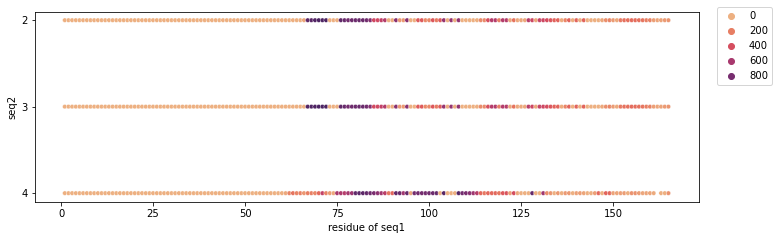

In [288]:
res = get_max_residues(get_summary_lib(filename))
res["library"] = "TEST2"
n = 1
plot_library(res, n)

In [252]:
seq_indexes

,index,seq_name,seq,seq_3di
0,1,A,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...
0,2,B,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQP...,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDPPVVPLQQP...
0,3,C,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD...
0,4,D,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVV...,DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDAQPVPDDVVLVV...


In [4]:
def modify_value(line, newval):
    # Split the line into a list of values using tabs as the separator    
    values = line.split()
    if len(values) >= 3:
        values[2] = str(newval)
    # Join the modified values back into a single line using tabs
    modified_line = "\t".join(values)
    return modified_line+"\n"


def mod_lib(library, newval, filename): 
    with open(filename, 'w') as file:
        file1 = open(library, 'r')
        Lines = file1.readlines()
        count = 0
        header_finished = False
        seq_indexes = pd.DataFrame()
        residues = pd.DataFrame()
        # Strips the newline character
        for line in Lines:
            line_print = line
            if line.startswith("!"):
                count += 1
                file.write(line_print)
                continue
            if count == 0:
                count += 1
                file.write(line_print)
                continue
            elif count == 1: 
                nseq = int(line)
                count += 1
                file.write(line_print)
                continue
            elif count == nseq+2: 
                header_finished = True
            if not header_finished: 
                count += 1
            else:
                if not line.startswith("#"): 
                    line_print = modify_value(line, newval)
            file.write(line_print)

In [8]:
library = "test1.lib"

In [9]:
N = 3  # Change this value to the desired threshold

with open(library, 'r') as input_file, open(outname, 'w') as output_file:
    # Read the header line
    header = input_file.readline().rstrip()
    output_file.write(header + '\n')
    
    # Read the first row
    line = input_file.readline()
    prev_residue = int(line.split()[1])
    current_stretch = 1
    
    for line in input_file:
        residue = int(line.split()[1])
        
        if residue == prev_residue + 1:
            current_stretch += 1
        else:
            current_stretch = 1
        
        if current_stretch > N:
            output_file.write(line)
        
        prev_residue = residue

IndexError: list index out of range

In [64]:
library = "./test1.lib"
outfile = "a.lib"
N = 1
newval=100

def init_vals(): 
    return(1,-1, "", "prev")


def mod_lib(library, newval, N, filename, id_res = 1):
    with open(filename, 'w') as file:
        file1 = open(library, 'r')
        Lines = file1.readlines()

        # INIT
        header_finished = False
        current_stretch,prev_residue,line_stretch,prev_line = init_vals()
        
        for line in Lines: 
            
            if line.startswith("#"):
                
                if current_stretch > N:                    
                    file.write(line_stretch)
                file.write(line)
                
                header_finished = True
                current_stretch,prev_residue,line_stretch,prev_line = init_vals()
                continue    
            if not header_finished: 
                file.write(line)
                continue             
            
            if line.startswith("!") and header_finished == True:
                if current_stretch > N:                    
                    file.write(line_stretch)
                file.write(line)
                continue
            else:
                if not line.startswith("#"): 
                    residue = int(line.split()[id_res])
                    if residue == prev_residue + 1:
                        current_stretch += 1
                        line_stretch = line_stretch+modify_value(line, newval)
                    else:
                        if current_stretch > N:                    
                            file.write(line_stretch)
                        current_stretch = 1
                        line_stretch = modify_value(line, newval)
                    prev_residue = residue
                    prev_line = line                    

                



In [ ]:
def scale_lib(library, newval, N, filename):
    with open(filename, 'w') as file:
        file1 = open(library, 'r')
        Lines = file1.readlines()

        # INIT
        header_finished = False
        current_stretch,prev_residue,line_stretch,prev_line = init_vals()
        
        for line in Lines: 
            
            if line.startswith("#"):
                
                if current_stretch > N:                    
                    file.write(line_stretch)
                file.write(line)
                
                header_finished = True
                current_stretch,prev_residue,line_stretch,prev_line = init_vals()
                continue    
            if not header_finished: 
                file.write(line)
                continue             
            
            if line.startswith("!") and header_finished == True:
                if current_stretch > N:                    
                    file.write(line_stretch)
                file.write(line)
                continue
            else:
                if not line.startswith("#"): 
                    residue = int(line.split()[id_res])
                    if residue == prev_residue + 1:
                        current_stretch += 1
                        line_stretch = line_stretch+modify_value(line, newval)
                    else:
                        if current_stretch > N:                    
                            file.write(line_stretch)
                        current_stretch = 1
                        line_stretch = modify_value(line, newval)
                    prev_residue = residue
                    prev_line = line 

In [65]:
mod_lib(library, newval, N, outfile)
mod_lib(outfile, newval, N, "luisa.lib", 0)

In [56]:
file1 = open("luisa.lib", 'r')
Lines = file1.readlines()
for line in Lines:
    print(line)


FileNotFoundError: [Errno 2] No such file or directory: 'luisa.lib'

In [73]:
file1 = open(library, 'r')
Lines = file1.readlines()
for line in Lines:
    print(line)

! TC_LIB_FORMAT_01

8

1b26a 409 SLYEMAVEQFNRAASLMDLESDLAEVLRRPKRVLIVEFPVRMDDGHVEVFTGYRVQHNVARGPAKGGIRYHPDVTLDEVKALAFWMTWKTAVMNLPFGGGKGGVRVDPKKLSRNELERLSRRFFSEIQVIIGPYNDIPAPDVNTNADVIAWYMDTYSMNVGHTVLGIVTGKPVELGGSKGREEATGRGVKVCAGLAMDVLGIDPKKATVAVQGFGNVGQFAALLISQELGSKVVAVSDSRGGIYNPEGFDVEELIRYKKEHGTVVTYPKGERITNEELLELDVDILVPAALEGAIHAGNAERIKAKAVVEGANGPTTPEADEILSRRGILVVPDILANAGGVTVSYFEWVQDLQSFFWDLDQVRNALEKMMKGAFNDVMKVKEKYNVDMRTAAYILAIDRVAYATKKRG

1bgva 449 SKYVDRVIAEVEKKYADEPEFVQTVEEVLSSLGPVVDAHPEYEEVALLERMVIPERVIEFRVPWEDDNGKVHVNTGYRVQFNGAIGPYKGGLRFAPSVNLSIMKFLGFEQAFKDSLTTLPMGGAKGGSDFDPNGKSDREVMRFCQAFMTELYRHIGPDIDVPAGDLGVGAREIGYMYGQYRKIVGGFYNGVLTGKARSFGGSLVRPEATGYGSVYYVEAVMKHENDTLVGKTVALAGFGNVAWGAAKKLAELGAKAVTLSGPDGYIYDPEGITTEEKINYMLEMRASGRNKVQDYADKFGVQFFPGEKPWGQKVDIIMPCATQNDVDLEQAKKIVANNVKYYIEVANMPTTNEALRFLMQQPNMVVAPSKAVNAGGVLVSGFEMSQNSERLSWTAEEVDSKLHQVMTDIHDGSAAAAERYGLGYNLVAGANIVGFQKIADAMMAQGIAW

1bvua 416 QDPFEIAVKQLERAAQYMDISEEALEFLKRPQRIVEVSIPVEMDDGSVKVFTGFRVQYNWARGPTKGGIRWHPEETLSTVKALAA

In [194]:
# TEST lib collapsing
import numpy as np 
np.array([1,2]).max()

2

In [52]:
def aggsum(x):
    x = x.astype(float)
    x = x.sum()
    return(x.astype(str))

def aggmax(x):
    x = x.astype(float)
    x = x.max()
    return(str(x))

def print_chunk(entries, file, aggfunc = "sum"):
    for i in entries: 
        if aggfunc == "sum": 
            df = pd.DataFrame(entries[i]).groupby([0,1]).agg({2: aggsum, 3: 'first', 4: 'first'}).reset_index()
        elif aggfunc == "max": 
            df = pd.DataFrame(entries[i]).groupby([0,1]).agg({2: aggmax, 3: 'first', 4: 'first'}).reset_index()
        for x in df.values.tolist(): 
            file.write("\t".join(x)+"\n")

def sum_lib(library,filename, aggfunc = "max"):
    with open(filename, 'w') as file:
        file1 = open(library, 'r')
        Lines = file1.readlines()

        
        # INIT
        header_finished = False
        entries = {}
        
        for line in Lines: 
            
            # Change of pair
            if line.startswith("#"):
                if header_finished:
                    print_chunk(entries, file,aggfunc) 
                    entries = {}
                file.write(line)
                header_finished = True
                continue    

            # Prefix 
            if not header_finished: 
                file.write(line)
                continue             
            # Suffix
            if line.startswith("!") and header_finished == True:
                print_chunk(entries, file, aggfunc) 
                entries = {}
                file.write(line)
                continue
            else:
                # Within each pair
                if not line.startswith("#"): 
                    residue = int(line.split()[0])
                    if residue in entries:
                        entries[residue].append(line.split())
                    else: 
                        entries[residue] = [line.split()]



In [9]:
library = "test1.lib"
outfile = "a"
sum_lib(library, outfile, "max")

In [162]:
def sum_lib(library_A, filename, aggfunc = "max"):
    with open(filename, 'w') as file:
        file1 = open(library_A, 'r')
        Lines = file1.readlines()

        
        # INIT
        header_finished = False
        entries = {}
        
        for line in Lines: 
            
            # Change of pair
            if line.startswith("#"):
                seq_pair = line
                if header_finished:
                    print_chunk(entries, file,aggfunc) 
                    entries = {}
                file.write(line)
                header_finished = True
                continue    

            # Prefix 
            if not header_finished: 
                file.write(line)
                continue             
            # Suffix
            if line.startswith("!") and header_finished == True:
                print_chunk(entries, file, aggfunc) 
                entries = {}
                file.write(line)
                continue
            else:
                # Within each pair
                if not line.startswith("#"): 
                    residue = int(line.split()[0])
                    if residue in entries:
                        entries[residue].append(line.split())
                    else: 
                        entries[residue] = [line.split()]

In [24]:
library_A = "./test1.lib"



In [91]:
def aggsum(x):
    x = x.astype(float)
    x = x.sum()
    return(x.astype(str))

def aggmax(x):
    x = x.astype(float)
    x = x.max()
    return(str(x))


def lib_to_dict(library):
    file1 = open(library, 'r')
    Lines = file1.readlines()


    # INIT
    header_finished = False
    entries = {}

    for line in Lines: 

        # Change of pair
        if line.startswith("#"):
            seq_pair = line
            header_finished = True
            continue    
        # Prefix 
        if not header_finished: 
            continue
        if line.startswith("!") and header_finished == True:
            continue
        # Within each pair
        if not line.startswith("#"): 
            if seq_pair in entries:
                entries[seq_pair].append(line.split())
            else: 
                entries[seq_pair] =  [line.split()]
    return(entries)



def print_chunk(entries_A, entries_B, file, aggfunc = "sum"):
    entries = pd.concat([pd.DataFrame(entries_A), pd.DataFrame(entries_B)])
    if aggfunc == "sum": 
        df = entries.groupby([0,1]).agg({2: aggsum, 3: 'first', 4: 'first'}).reset_index()
    elif aggfunc == "max": 
        df = entries.groupby([0,1]).agg({2: aggmax, 3: 'first', 4: 'first'}).reset_index()
    # Sort 
    df[0] = df[0].astype(int)
    df[1] = df[1].astype(int)
    df = df.sort_values([0,1])
    df[0] = df[0].astype(str)
    df[1] = df[1].astype(str)   
    for x in df.values.tolist(): 
        file.write("\t".join(x)+"\n")


def print_entries(entries_A, entries_B, file): 
    for i in entries_A: 
        file.write(entries_A[i])
        file.write(entries_B[i])  

def combine_libs(library_A, library_B, aggfunc, filename): 
    with open(filename, 'w') as file:

        entries_library_B = lib_to_dict(library_B)

        file1 = open(library_A, 'r')
        Lines = file1.readlines()

        # INIT
        header_finished = False
        entries = {}

        for line in Lines: 

            # Change of pair
            if line.startswith("#"):
                if header_finished: 
                    print_chunk(entries[seq_pair], entries_library_B[seq_pair], file, aggfunc)
                entries  ={}
                seq_pair = line
                file.write(line)
                header_finished = True
                continue    
            # Prefix 
            if not header_finished:
                file.write(line)
                continue
            if line.startswith("!") and header_finished == True:
                print_chunk(entries[seq_pair], entries_library_B[seq_pair], file, aggfunc)
                file.write(line)
                continue
            # Within each pair
            if not line.startswith("#"): 
                if seq_pair in entries:
                    entries[seq_pair].append(line.split())
                else: 
                    entries[seq_pair] = [line.split()]


In [90]:
combine_libs("test1.lib", "test2.lib","max" , "hey") 

#1 2

#1 3



In [28]:
library_A = "test1.lib"
library_B = "test2.lib"

entries_library_A = lib_to_dict(library_A)
entries_library_B = lib_to_dict(library_B)



In [47]:
entries_A = entries_library_A['#1 2\n']
entries_B = entries_library_B['#1 2\n']

,0,1,2,3,4
0,1,1,810,4,0
1,1,19,28,4,0
2,1,19,29,4,0
3,1,20,53,4,0
4,2,2,764,4,0
5,2,3,14,4,0
6,2,4,11,4,0
7,2,5,11,4,0
8,1,6,90,4,0
0,1,1,900,4,0


In [79]:
df = pd.DataFrame(entries).groupby([0,1]).agg({2: aggsum, 3: 'first', 4: 'first'}).reset_index()


,0,1,2,3,4
0,1,1,1710.0,4,0
3,1,6,90.0,4,0
1,1,19,114.0,4,0
2,1,20,106.0,4,0
4,2,2,1528.0,4,0
5,2,3,28.0,4,0
6,2,4,22.0,4,0
7,2,5,22.0,4,0


In [78]:

df

,0,1,2,3,4
0,1,1,1710.0,4,0
1,19,19,114.0,4,0
2,20,20,106.0,4,0
3,6,6,90.0,4,0
4,2,2,1528.0,4,0
5,3,3,28.0,4,0
6,4,4,22.0,4,0
7,5,5,22.0,4,0


In [30]:
entries_library_B[i]


[['1', '1', '900', '4', '0'],
 ['1', '19', '28', '4', '0'],
 ['1', '19', '29', '4', '0'],
 ['1', '20', '53', '4', '0'],
 ['2', '2', '764', '4', '0'],
 ['2', '3', '14', '4', '0'],
 ['2', '4', '11', '4', '0'],
 ['2', '5', '11', '4', '0']]